# All the President's Moods

In the past decade, a certain public figure has been very active on Twitter...

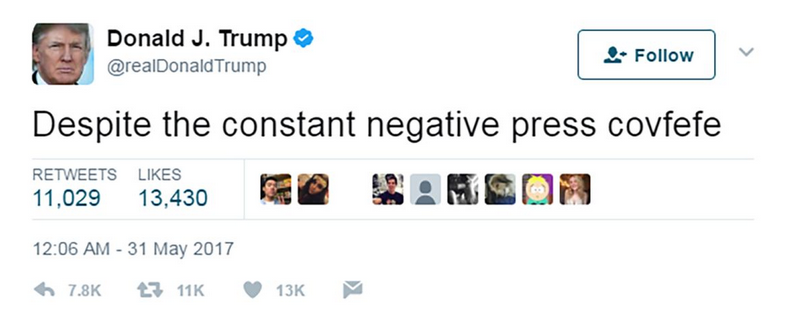

## Trump and Twitter

During his tenure as US President, Donald Trump maintained a steady presence on Twitter. Since the words of the politicians tend to affect the behavior of other people, including markets, there is a sizable literature quantifying the effect of politician speeches on market behavior in the aggregate. 


## Case Study: The 2020 Election

Unllke other politicians, Trump's tweets were both impassioned and plentiful. This means Twitter can give a large volume of reactions to work with that have a distribution of "sentiment."

In this example, we will look at Trump's tweets around the 2020 election. 

In [ ]:
import pandas as pd
import json 
import matplotlib.pyplot as plt
import matplotlib
import re
import string
from nltk.corpus import stopwords
import regex
import nltk
from datetime import timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## 1. Read Tweets

Reading Trump Tweets

In json format:

In [ ]:
dir_ = "C:/Users/jhtchns2/Box/ACE_592_SAE/Class_Examples/1_Text/"
with open(dir_+"Trump_tweets.json") as f:
    tweets = json.load(f)

Let's extract some features and put them in a dataframe:

In [ ]:
df = pd.DataFrame()

# Full text
df['full_text'] = [x['full_text'] for x in tweets]

# User mentions (list)
df['user_mentions'] = [[ x['screen_name'] for x in y['entities']['user_mentions'] ] for y in tweets]

# Number of times its been retweeted
df['RTs'] = [x['retweet_count'] for x in tweets]

# Number of likes
df['favs'] = [x['favorite_count'] for x in tweets]

# Censored tweets have zero RTs
df['censored'] = df['RTs']==0

### Note: extended text and retweets

In the case that there is an "extended_tweet" key, the "full_text" key does not exit.

If that is the case, you have to extract it doing something like this: 

An inelegant solution:

In [ ]:
ext_text = []

for tweet in tweets:
    if "retweeted_status" in list(tweet.keys()): # Is one of the keys "retweeted_status"
        if "extended_tweet" in list(tweet['retweeted_status'].keys()): # Is one of they keys in "extended tweet"
            ext_text += [tweet['retweeted_status']['extended_tweet']['full_text']]
        else:
            ext_text += [tweet['retweeted_status']['full_text']] # If not, take "text"
    elif "extended_tweet" in list(tweet.keys()): # Is one of the keys "extended_tweet"
        ext_text += [tweet['extended_tweet']['full_text']]
    else:
        ext_text += [tweet['full_text']] # If not, take "text"

df['text'] = ext_text

Time features

In [ ]:
df['time_stamp'] = [x['created_at'] for x in tweets]

# Convert to CT time (its at Greenwich by default)
df['time_stamp'] = pd.to_datetime(df['time_stamp']) - timedelta(hours=6)

# Date, which is just chopping off the time part
df['date'] = df.time_stamp.apply(lambda x:  str(x)[:10])
df['date'] = pd.to_datetime(df.date)

To drop duplicates, I'll take the one with the most favorites.

In [ ]:
df = df.sort_values(by=['time_stamp','full_text',"favs"])

df = df.groupby(['time_stamp','full_text']).last().reset_index()

## Word Counts

### Top 10 Words
#### Remove Links and User Tags

I'm going to use regular expressions here

In [ ]:
import re

# Regex functions to find each one
find_links = re.compile(r'http\S+')
find_users = re.compile(r'@\w+')
find_hashtags = re.compile(r'#\w+')

# "sub" them for an empty string
df['text_nolink'] = [find_links.sub("",x) for x in df['full_text']]
df['text_nolink'] = [find_users.sub("",x) for x in df['text_nolink']]
df['text_nolink'] = [find_hashtags.sub("",x) for x in df['text_nolink']]

#### Remove punctuation and lowercase

In [ ]:
import string
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”')

df['text_lower'] =  df['text_nolink'].str.lower().str.replace("\n"," ")

df['text_clean'] = df.text_lower.str.translate(remv_punc)

#### Split into words

In [ ]:
from nltk.corpus import stopwords

sw_list = stopwords.words('english') + ['amp',''," "]

df['words'] = [x.split(" ") for x in df['text_clean']]

#### Take out Stop Words

In [ ]:
df['words'] = [list(set(x) - set(sw_list)) for x in df['words']]

#### Get the words counts

Slow way:

In [ ]:
series_list = [pd.Series(x).value_counts() for x in df['words']]
word_df = pd.concat(series_list,axis=1).fillna(0).T.reset_index(drop=True)

In [ ]:
word_df.sum().sort_values(ascending=False).head(20)

If the data is big, that method is very memory and time-consuming.

I am going to use an sklean vectorizer here. Part of the reason sklearn is more efficient in this case is that it uses __sparse matrices__ to do the computations.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vct = CountVectorizer(stop_words=sw_list)

X = vct.fit_transform(list(df['text_clean']))

In [ ]:
X

This matrix currently holds 17k entries, but somehow does it efficiently. How?

### Sparse Matrices
- Matrices where most of the elements are zero.
- If you are using int64, its taking up 64 bits just to put zeros. What a waste!
- One format is called __Compressed Sparse Row__ and holds this data more efficiently. From the Wikipedia page:
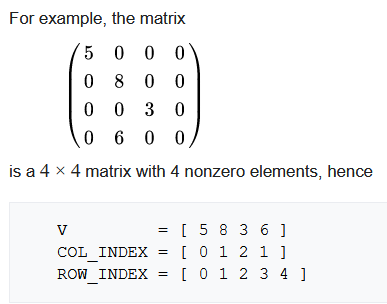    Holding three one-dimensional arrays is much more efficient than a giant two-dimensional array.

A handy feature here is that you can still do normal operations on a sparse matrix. I will sum it and then make it a dataframe:

In [ ]:
word_counts = pd.DataFrame(X.sum(axis=0))

I can label columns by extracting the "feature names"

In [ ]:
word_counts.columns = vct.get_feature_names_out()
word_counts = word_counts.T

Top 10 words

In [ ]:
word_counts[0].sort_values(ascending=False).head(20)

### Which of the words are hashtags and mentions?
How shall we find hashtags and mentions?

How you extract them is an exercise for you 

__(but here's a hint: CountVectorizer accepts regular expressions...)__

#### Bar Chart

In [ ]:
word_counts[0].sort_values(ascending=False).head(10).plot(kind='barh',figsize=(10,8))
plt.xlabel("Number of Times the Word is Used, August 30 - November 5")
plt.title("Trump in His Own Words \n",fontsize=16)
plt.savefig("trump_words.png",dpi=250,bbox_inches="tight")

### Most Favorited

In [ ]:
favor_5 = df.sort_values("favs",ascending=False).head()[['time_stamp','full_text','favs']]

favor_5.columns = ['Time Stamp',"Tweet",'Number of Favorites']

In [ ]:
pd.set_option('display.max_colwidth', None)
favor_5[['Tweet','Time Stamp',"Number of Favorites"]]

## Tweet Volume

In [ ]:
top20_dates = df.date.value_counts().head(20)

top20_dates

#### Some important dates:
- Sept 29th: First Presidential Debate
- Oct 15th: Planned Second Debate (which Trump refused to show up for).
- Oct 22nd: Final Debate
- Nov 3rd: Election Day

In [ ]:
dates = df.date.sort_values().drop_duplicates().reset_index(drop=True)

In [ ]:
df.date.value_counts().sort_index().plot(label="Number of Tweets",figsize=(10,5),lw=2)
plt.xticks(rotation=-45)

plt.axvline("2020-09-29",ls="--",color="black",label="First Debate",lw=3)
plt.axvline("2020-10-15",ls="-.",color="black",label="Second Debate",lw=3)
plt.axvline("2020-10-22",ls=":",color="black",label="Final Debate",lw=3)
plt.axvline("2020-11-03",ls="-",color="black",label="Election Day",lw=3)

plt.ylabel("Daily Number of Tweets")
plt.legend(loc="upper left")

#### Top 5 words on those days

In [ ]:
important_dates = ["2020-09-29","2020-10-15","2020-10-22","2020-11-03"]

In [ ]:
word_df = pd.concat([df[['date']],word_df],axis=1)

def top5_words(date):
    this_day = word_df[word_df.date==date]
    word_sums = this_day.iloc[:,1:].sum()
    top5_words = word_sums.sort_values(ascending=False).head().index
    return list(top5_words)

words_on_days = pd.DataFrame([top5_words(x) for x in top20_dates.index])

words_on_days.columns = [1,2,3,4,5]

words_on_days.index = top20_dates.index

In [ ]:
words_on_days

## Sentiment Analysis

In [ ]:
sid = SentimentIntensityAnalyzer()

pol_scores = [sid.polarity_scores(x)['compound'] for x in df['text_clean']]

df['sentiment'] = pd.Series(pol_scores)

In [ ]:
sent_ts = df.set_index("time_stamp").sort_index()

In [ ]:
f,a = plt.subplots(figsize=(20,10))
sent_ts['sentiment'].plot(alpha=.1,ax=a,color="black",label="Raw Score",lw=3)
df.groupby("date")['sentiment'].mean().plot(ax=a,label="Daily Average",lw=3)

# df.groupby("date")['sentiment'].mean().plot()
plt.axhline(0,color="black",ls="--")
# plt.xticks(rotation=-45)
plt.ylabel("Sentiment Score, Daily Average")
plt.xlabel("Date")

plt.legend()

#### What do the happiest and saddest tweets look like?

In [ ]:
df.set_index("time_stamp").sort_values("sentiment")[['full_text','sentiment']].head()

The top two saddest tweets are about terrorism and assasination, the rest have an agressive tone speaking about various people.

In [ ]:
df.set_index("time_stamp").sort_values("sentiment",ascending=False)[['full_text','sentiment']].head()

Notice the happy tweets have things like "happy," "blessed," "winner," and so forth.

### "Happiest and Saddest Words"

#### Words that correlate with sentiment.
correlate word counts with sentiment score.

In [ ]:
sent_words_corr = word_df.join(df[['sentiment']]).corr()['sentiment']

###### Bad words

In [ ]:
sent_words_corr.sort_values().head(20)

Besides the typical negative words, "Biden," "fake," and "news," "swine," and "ballots" are notable exceptions. While these are not necessarily bad words by themselves, what this shows is the Trump combines these words with other negative words.

###### Good Words

In [ ]:
sent_words_corr.sort_values(ascending=False).head(21)

Most of these are good words already, but notice "congressman," "vets," "amendment" (referring to second amendment), and "America" as words that Trump includes in his most positive tweets.

## Trump and the Stock Market

Did Trump's tweeting affect stock prices?

### First discuss in groups!
- What is the mechanism by which Trump tweeting would affect markets?
- What direction do you expect the effect to be?

We can merge some data in to examine the series together...

In [ ]:
sp500 = pd.read_csv(dir_+"SandP500.csv")

### A note on data merging:
In order for the merge to work, each data source needs to be at the same level.

In this case:
- Tweets are at the second level
- Prices are at the daily level

So make sure some column exists in both datasets to merge on:

In [ ]:
# Create date column in the price data
sp500['date'] = pd.to_datetime(sp500['DATE'])

# Do a merge on this new column
df = df.merge(sp500,how='left',on='date',indicator='i_')

# Coerce to numeric
df['SP500'] =pd.to_numeric(df['SP500'],errors='coerce')

# Done!
price_and_sent = df.groupby("date")[['sentiment','SP500']].mean()

In [ ]:
f,a = plt.subplots(figsize=(10,6))

price_and_sent['sentiment'].plot(ax=a,label="Sentiment")
plt.axhline(0,color="black",ls="--")
plt.legend(loc='upper left')
a.set_ylim(-1,1)
a2 = a.twinx()

# price_and_sent['SP500'].rolling(7,min_periods=1).mean().plot(ax=a2,color='red',label="S&P 500, 7 day average")
price_and_sent['SP500'].plot(ax=a2,color='red',label="S&P 500, 7 day average")

plt.legend()

### Group Discussion:
how you would answer the question: "Did President Trump's tweet sentiment influence the stock market?" Specifically describe:
- The data you would need in addition to these data sources.
- The way you would read in the data and manipulate it.
- The sort of analysis or statistics you would calculate to answer the question.

In [ ]:
price_and_sent.corr()

There is a somehwhat strong correlation between Trump's sentiment and S&P 500, but it is __negative__: the more positive Trump's Tweets are the lower stock prices are. A couple of possibilities:
- Spurious correlation ([for example](https://www.tylervigen.com/spurious-correlations)).
- Omitted variable bias: there is something that drives Trump's sentiment but also drives stock prices, which makes the relationship look stronger than it actually is. Certain events may be to blame more than Trump or the stock market; for example, certain events could be affecting both in opposite ways. This means it is __not a causal relationship__.
- Trump interprets things positively that the market inteprets as bullish. For example, many positive Trump tweets were congratulating the victories of certain politicians or policies that market may not welcome. This would __not be a causal relationship__. 
- Trump's comments during this period promoted distrust in institutions (such as mail-in voting) and were thought of as destabilizing, which the market may have interpreted as a bad signal for the economy. This would also be a __causal relationship__.

Note that the sizable jump in the stock market following November 3 indicate that Trump leaving office did appear to affect markets, since that was the most major event happening at the time.